### Find the vertices of the `stoich_subspace()` 

The stoichiometric subspace is a region in concentration space wherein all feasible concentrations must lie.  It forms the upper bounds in concentration space in which the true attainable region must reside. The feed point $ C_f $ always forms one bound of the set concentrations achievable in state space from which the stoichiometric subspace originates. The set of concentrations in this space must obey reaction stoichiometry. As a result, not all concentrations in the stoichiometric subspace will be "practically achievable". Thus, the stoichiometric subspace is typically much larger than the set of 'attainable' points. For $ n $ components participating in $ d $ reactions, the true AR must reside in a d-dimensional subspace in $ ℝ^n $. It follows that the dimension $ d $, is the number of linearly independent reactions $ {rank(A)} $ present in the system. 

For any specified feed vector $ C_f $ and extent of reaction $ \varepsilon $, the set of stoichiometrically compatible concentrations must lie within a region spanned by the feed vector and stoichiometric coefficient vector $ A $ in concentration space. As a consequence of the physical meaning of achievable concentrations, mass balance and non-negativity constraints are imposed, further restricting the set of physically attainable concentrations. This implies that every point $ c_i $ within the stoichiometric subspace must reside in the positive orthant of the 'real' concentration space. Furthermore, it must be stoichiometrically compatible with the given reaction stoichiometry. 

The stoichiometric subspace is denoted by the letter $ S $ and it obeys the following vector equation parameterized by the extent of reaction;

$ {C = C_f + A\varepsilon} $

Where;

$ C_f $ : feed vector
    
$ A $ : stoichiometric coefficient A, with the size $ {n x d} $
    
$ \varepsilon $ : extent vector corresponding to each reaction taking part in the system

Computing the stoichiometric subspace for a single feed is done by identifying the bounding constraints in extent space that form the stoichiometric subspace. Vertex enumeration is employed to find the extreme vertices in extent space that constitute the feasible region. Hence, we find the vertices of the convex polytope, $ S $, in $ ℝ^n $ i.e. by computing the convex hull of the stoichiometric subspace polytope described by the following inequality constraints;

$ {C_f + A\varepsilon \geq 0 } $

The ` con2vert()` function in the `artools package` is deployed in solving the vertex enumeration problem. Since the stoichiometric subspace is a function of both the reaction stoichiometry and the feed point, the shape of the stoichiometric subspace will change if the feed point is changed. This implies that every feed point has an associated stoichiometric subspace, $ S $. Hence, it can be deduced that; the set of concentrations belonging to the overall stoichiometric subspace, $ S_{tot} $, may be found by computing convex hull of the individual stoichiometric subspaces;

$ S_{tot} = conv ({S_1, S_2, S_3, ..., S_N}) $ 

Mixing between individual stoichiometric subspaces increases the dimension of the overall stoichiometric subspace. Hence, in systems with multiple feeds, the dimension of the AR exceeds the number of independent reactions. 

### Imports

In [2]:
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from __future__ import division

%matplotlib inline

In [3]:
import sys
sys.path.append('../artools/')
import artools
artools = reload(artools)

### Define `stoich_subspace()`

In [4]:
def stoich_subspace(Cf0s, stoich_mat):
    """ Compute the bounds of the stoichiometric subspace, S, from multiple feed points
    and a stoichoimetric coefficient matrix.

    Parameters:
        stoich_mat  (n x d) array. Each row in stoich_mat corresponds to a component
                    and each column corresponds to a reaction.
        Cf0s        (M x n) matrix. Each row in Cf0s corresponds to an individual 
                    feed and each column corresponds to a component.

    Returns:
        stoichSubspace_attributes   dictionary that contains the vertices stoichiometric 
                                    subspace in extent and concentration space for individual 
                                    feeds as well as overall stoichiometric subspace for multiple
                                    feeds.                         
        keys:
        
        all_Es      The vertices of individual stoichiometric subspaces in extent space.
        
        all_Cs      The vertices of individual stoichiometric subspaces in concentration space.
        
        all_Es_mat  list of vertices of the overall stoichiometric subspace in extent space.
        
        all_Cs_mat  list of vertices of the overall stoichiometric subspace in concentration space.
        
        hull_Es     extreme vertices of the overall stoichiometric subspace in the extent space.              
        
        hull_Cs     extreme vertices of the overall stoichiometric subspace in concentration space.

    """
    
    # to store stoichSubspace_attributes
    stoichCoeff_attributes = {}
    
    # to store vertices for each feed and stoich_mat in extent and concentration space  
    all_Es = []
    all_Cs = []
    
    # if user input is not a list, then convert into a list 
    if not isinstance(Cf0s, list) and not Cf0s.shape[0] > 1 and not Cf0s.shape[1] > 1:
        # put it in a list 
        Cf0s = [Cf0s]
    
    for Cf0 in Cf0s:
        # loop through each feed point, Cf0, and check if it is a column vector 
        # with ndim=2, or a (L,) array with ndim=1 only
        if Cf0.ndim == 2:
            Cf0 = Cf0.flatten() # converts into (L,)
            
        # raise an error if the no. of components is inconsistent between the feed and stoichiometric matrix
        if len(Cf0) != stoich_mat.shape[0]:
            raise Exception("The number of components in the feed does not match the number of rows in the stoichiometric matrix.")
            
        # always treat stoich_mat as a matrix for consistency, convert if not
        if stoich_mat.ndim == 1: 
            # converts a 'single rxn' row into column vector  
            stoich_mat = stoich_mat.reshape((len(stoich_mat), 1)) 

        # check if  a single reaction or multiple reactions are occuring  
        if stoich_mat.shape[1] == 1 or stoich_mat.ndim == 1: 
            # if stoich_mat is (L,) array this'stoich_mat.shape[1]' raises an error 'tuple out of range'  
            
            # converts into (L,)
            stoich_mat = stoich_mat.flatten()

            # calculate the limiting requirements
            limiting = Cf0/ stoich_mat

            # only choose negative coefficients as these indicate reactants
            k = limiting < 0.0

            # calc maximum extent based on limiting reactant and calc C
            # we take max() because of the negative convention of the limiting requirements 
            e_max = sp.fabs(max(limiting[k]))
            
            # calc the corresponding point in concentration space 
            C = Cf0 + stoich_mat*e_max

            # form Cs and Es and return
            Cs = sp.vstack([Cf0, C])
            Es = sp.array([[0., e_max]]).T

        else:
            # extent associated with each feed vector
            Es = artools.con2vert(- stoich_mat, Cf0) 
            
            # calc the corresponding point in concentration space
            Cs = (Cf0[:, None] + sp.dot(stoich_mat, Es.T)).T 

        # vertices for each feed and stoich_mat in extent and concentration space
        all_Es.append(Es) 
        all_Cs.append(Cs)

        # stack vertices in one list and find the overall stoichiometric subspace(convex hull) 
        all_Es_mat = sp.vstack(all_Es)
        all_Cs_mat = sp.vstack(all_Cs)
        
    # convexHull vertices for the overall stoichiometric subspace in extent space         
    hull_all = ConvexHull(all_Es_mat)
    ks = hull_all.vertices
    hull_Es = all_Es_mat[ks, :]

    # convexHull vertices for the overall stoichiometric subspace in concentration space
    hull_all = ConvexHull(all_Cs_mat)
    ks = hull_all.vertices
    hull_Cs = all_Cs_mat[ks, :] 

    # create a dictionary containing all the 'attributes' of the 'stoich_subspace'
    stoichCoeff_attributes = {
        'all_Es' : all_Es,
        'all_Cs' : all_Cs,
        'all_Es_mat' : all_Es_mat,
        'all_Cs_mat' : all_Cs_mat,
        'hull_Es' : hull_Es,
        'hull_Cs' : hull_Cs
}
        
    return stoichCoeff_attributes

## Check to see that dimension exception gets raised

The following example should raise an exception as the number of components in the feed does not match the number of rows in the stoichiometric matrix

In [5]:
stoich_mat = sp.array([[-1, 1, 0, 0], [0, -1, 1, 0], [-2, 0, 0, 1]]).T

# feed vectors are only three components long
Cf1 = sp.array([1, 0, 0])
Cf2 = sp.array([1.5, 0.1, 0])
Cf3 = sp.array([0.5, 0.5, 0.5])
Cf0s = [Cf1, Cf2, Cf3]

stoichMat_attributes = stoich_subspace(Cf0s, stoich_mat)
stoichMat_attributes['all_Cs']

Exception: The number of components in the feed does not match the number of rows in the stoichiometric matrix.

### Supply a list of 1D numpy arrays in `Cf0s` 

In [6]:
stoich_mat = sp.array([[-1, 1, 0, 0], [0, -1, 1, 0], [-2, 0, 0, 1]]).T

Cf1 = sp.array([1., 0, 0, 0])
Cf2 = sp.array([1.5, 0.1, 0, 0])
Cf3 = sp.array([0.5, 0.5, 0.5, 0.5])
Cf0s = [Cf1, Cf2, Cf3]

stoichMat_attributes = stoich_subspace(Cf0s, stoich_mat)
ccs = stoichMat_attributes['hull_Cs']
ccs

array([[  0.00000000e+00,  -8.32667268e-17,   2.77555756e-17,
          5.00000000e-01],
       [ -4.44089210e-16,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00],
       [  1.00000000e+00,   2.77555756e-17,   2.77555756e-17,
          0.00000000e+00],
       [ -2.22044605e-16,   1.00000000e+00,   0.00000000e+00,
          2.22044605e-16],
       [  2.22044605e-16,   1.11022302e-16,   1.11022302e-16,
          1.25000000e+00],
       [  2.22044605e-16,  -1.55431223e-15,   2.50000000e+00,
          1.33226763e-15],
       [  2.50000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -6.66133815e-16,   2.50000000e+00,   0.00000000e+00,
          3.33066907e-16]])

In [7]:
ConvexHull(ccs).vertices


array([0, 1, 2, 3, 4, 5, 6, 7])

## Try when `Cf0s` is now a matrix of feeds (each row is a different feed)

In [8]:
Cf0s = sp.vstack([Cf1, Cf2, Cf3])

stoichMat_attributes = stoich_subspace(Cf0s, stoich_mat)
stoichMat_attributes['all_Cs']

[array([[  0.00000000e+00,  -8.32667268e-17,   2.77555756e-17,
           5.00000000e-01],
        [ -4.44089210e-16,   0.00000000e+00,   1.00000000e+00,
           0.00000000e+00],
        [  1.00000000e+00,   2.77555756e-17,   2.77555756e-17,
           0.00000000e+00],
        [ -2.22044605e-16,   1.00000000e+00,   0.00000000e+00,
           2.22044605e-16]]),
 array([[ -2.22044605e-16,  -5.55111512e-17,  -2.49800181e-16,
           8.00000000e-01],
        [  0.00000000e+00,  -5.27355937e-16,   1.60000000e+00,
           1.66533454e-16],
        [  1.60000000e+00,   8.32667268e-17,  -1.11022302e-16,
          -5.55111512e-17],
        [  0.00000000e+00,   1.60000000e+00,   0.00000000e+00,
           5.55111512e-17]]),
 array([[  2.22044605e-16,   1.11022302e-16,   1.11022302e-16,
           1.25000000e+00],
        [  2.22044605e-16,  -1.55431223e-15,   2.50000000e+00,
           1.33226763e-15],
        [  2.50000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+

## Now try to do single reactions

In [9]:
stoich_subspace(Cf0s, stoich_mat)


{'all_Cs': [array([[  0.00000000e+00,  -8.32667268e-17,   2.77555756e-17,
            5.00000000e-01],
         [ -4.44089210e-16,   0.00000000e+00,   1.00000000e+00,
            0.00000000e+00],
         [  1.00000000e+00,   2.77555756e-17,   2.77555756e-17,
            0.00000000e+00],
         [ -2.22044605e-16,   1.00000000e+00,   0.00000000e+00,
            2.22044605e-16]]),
  array([[ -2.22044605e-16,  -5.55111512e-17,  -2.49800181e-16,
            8.00000000e-01],
         [  0.00000000e+00,  -5.27355937e-16,   1.60000000e+00,
            1.66533454e-16],
         [  1.60000000e+00,   8.32667268e-17,  -1.11022302e-16,
           -5.55111512e-17],
         [  0.00000000e+00,   1.60000000e+00,   0.00000000e+00,
            5.55111512e-17]]),
  array([[  2.22044605e-16,   1.11022302e-16,   1.11022302e-16,
            1.25000000e+00],
         [  2.22044605e-16,  -1.55431223e-15,   2.50000000e+00,
            1.33226763e-15],
         [  2.50000000e+00,   0.00000000e+00,   0.000000

### Test 3 components participating in 3 reactions 

C:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


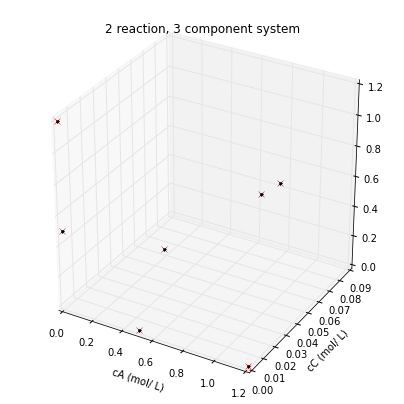

In [10]:
stoich_mat =sp.array([[-1, -1, 1], [-1, 0, 1]]).T

Cf1 = sp.array([1., 1., 0.])
Cf2 = sp.array([1., 1., 0.2])
Cf3 = sp.array([0.5, 0.5, 0.])
Cf0s = [Cf1, Cf2, Cf3]

stoichMat_attributes = stoich_subspace(Cf0s, stoich_mat)
tmp_hull_Cs = stoichMat_attributes['all_Cs_mat']
tmp_hull_Cs = stoichMat_attributes['hull_Cs']

%matplotlib inline
fig1 = plt.figure(figsize=(7, 7))
ax1 = fig1.gca(projection = '3d')

# plot points
plt.plot( tmp_hull_Cs[:, 0], tmp_hull_Cs[:, 1], tmp_hull_Cs[:, 2], 'rx')

#plot hull_points
ax1.plot(tmp_hull_Cs[:, 0], tmp_hull_Cs[:, 1], tmp_hull_Cs[:, 2], 'k.')

ax1.set_xlabel('cA (mol/ L)')
ax1.set_ylabel('cB (mol/ L)')
ax1.set_ylabel('cC (mol/ L)')
ax1.set_title('2 reaction, 3 component system')

plt.show()

